## Import packages

In [1]:

import torch
from sklearn.metrics import ConfusionMatrixDisplay

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (16, 9)

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
from config import opt
from models import DiscMNISTModel, DenoiserMNISTModel
from utils import get_dataloaders, get_val_metrics, init_seeds
from datasets.preprocessing import train_disc_transformations, val_disc_transformations, train_autoencoder_transformations, val_autoencoder_transformations, target_transform

In [4]:
init_seeds(opt.seed)

## Prepare dataset

In [5]:
train_autoencoder_loader, val_autoencoder_loader, train_disc_loader, val_disc_loader = get_dataloaders(
    train_disc_transformations, val_disc_transformations, train_autoencoder_transformations, val_autoencoder_transformations, target_transform
)

## Model performance metrics

In [6]:
class DenoiseDisc(torch.nn.Module):
    def __init__(self, disc, denoise):
        super(DenoiseDisc, self).__init__()
        self.disc = disc
        self.denoiser = denoise
        
    def forward(self, x):
        return self.disc(self.denoiser(x))

In [7]:
input_dim = (1, opt.img_height, opt.img_width)

In [8]:
disc_model = DiscMNISTModel(
    input_dim, opt.n_classes, opt.disc_hidden_channels,
).to(opt.device)

last_state = torch.load(str(opt.path_to_models / f'{disc_model.__class__.__name__}_model_best.pth'))
disc_model.load_state_dict(last_state['state_dict'])

<All keys matched successfully>

In [9]:
denoise_model = DenoiserMNISTModel(
    input_dim[0], opt.autoencoder_hidden_channels, opt.encoder_out_channels
).to(opt.device)

last_state = torch.load(str(opt.path_to_models / f'{denoise_model.__class__.__name__}_model_best.pth'))
denoise_model.load_state_dict(last_state['state_dict'])

<All keys matched successfully>

In [10]:
denoise_disc = DenoiseDisc(disc_model, denoise_model)

### Validation set without noise

In [11]:
acc_metric, f1_metric, precision_metric, recall_metric, conf_matrix = get_val_metrics(val_disc_loader, disc_model, opt.device, add_noise=False)
print(f'Accuracy: {acc_metric:.3}')
print(f'F1: {f1_metric:.3}')
print(f'Precision: {precision_metric:.3}')
print(f'Recall: {recall_metric:.3}')

batch loop: 100%|██████████| 40/40 [00:01<00:00, 28.84it/s]

Accuracy: 0.965
F1: 0.965
Precision: 0.966
Recall: 0.965


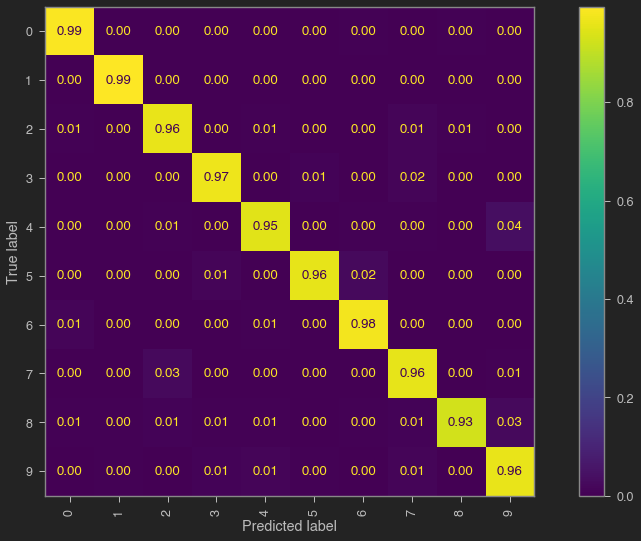

In [12]:
disp = ConfusionMatrixDisplay(
    confusion_matrix=conf_matrix / conf_matrix.astype('float').sum(axis=1, keepdims=True),
)
disp.plot(xticks_rotation='vertical', values_format='.2f');

### Validation set with noise

In [13]:
acc_metric, f1_metric, precision_metric, recall_metric, conf_matrix = get_val_metrics(val_disc_loader, disc_model, opt.device, add_noise=True)
print(f'Accuracy: {acc_metric:.3}')
print(f'F1: {f1_metric:.3}')
print(f'Precision: {precision_metric:.3}')
print(f'Recall: {recall_metric:.3}')

batch loop: 100%|██████████| 40/40 [00:01<00:00, 27.14it/s]

Accuracy: 0.909
F1: 0.909
Precision: 0.91
Recall: 0.909


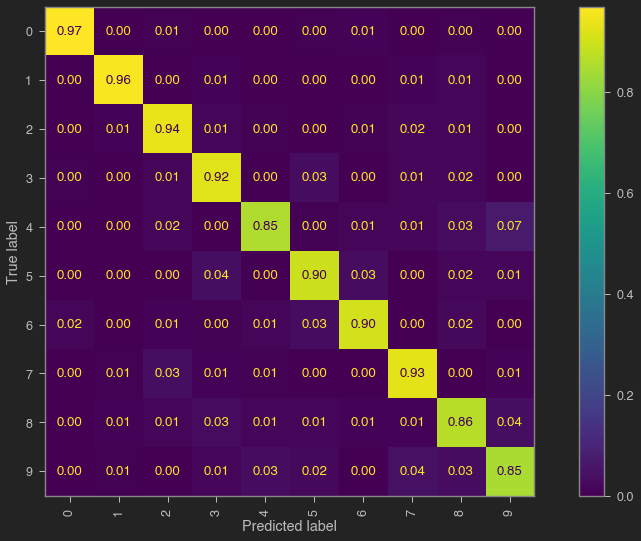

In [14]:
disp = ConfusionMatrixDisplay(
    confusion_matrix=conf_matrix / conf_matrix.astype('float').sum(axis=1, keepdims=True),
)
disp.plot(xticks_rotation='vertical', values_format='.2f');

### Denoised Validation set

In [15]:
acc_metric, f1_metric, precision_metric, recall_metric, conf_matrix = get_val_metrics(val_disc_loader, denoise_disc, opt.device, add_noise=True)
print(f'Accuracy: {acc_metric:.3}')
print(f'F1: {f1_metric:.3}')
print(f'Precision: {precision_metric:.3}')
print(f'Recall: {recall_metric:.3}')

batch loop: 100%|██████████| 40/40 [00:05<00:00,  7.65it/s]

Accuracy: 0.938
F1: 0.938
Precision: 0.939
Recall: 0.938


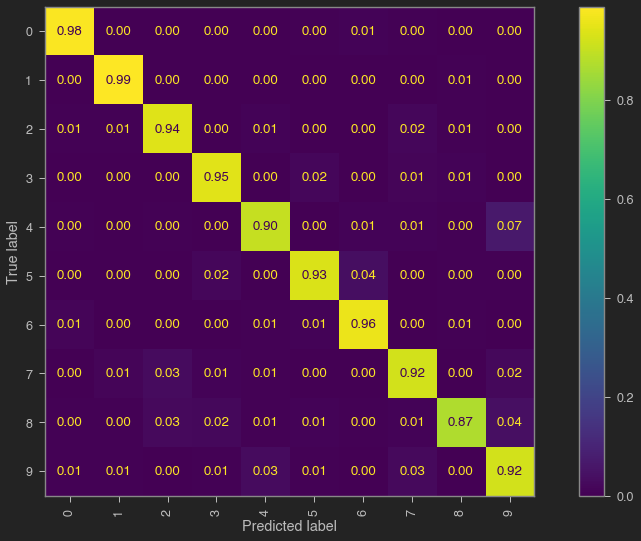

In [16]:
disp = ConfusionMatrixDisplay(
    confusion_matrix=conf_matrix / conf_matrix.astype('float').sum(axis=1, keepdims=True),
)
disp.plot(xticks_rotation='vertical', values_format='.2f');